# __Exploratory Data Analysis (EDA)__

## 1. Import necessary libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## 2. Load data as a Pandas DataFrame

In [2]:
path_irrad = "../data/G07A_DATOS_IRRAD.csv"
df_orig_irrad = pd.read_csv(path_irrad)

# Parse the date (string) for it to be a datetime with format yyyy/mm/dd
df_orig_irrad['FECHA'] = pd.to_datetime(df_orig_irrad['FECHA'], format='%Y-%m-%d')

s = df_orig_irrad.loc[:,'FECHA']
df_orig_irrad['FECHA'] =  s.dt.date

df_orig_irrad.head()

,FECHA,IRRADH00,IRRADH03,IRRADH06,IRRADH09,IRRADH12,IRRADH15,IRRADH18,IRRADH21,ANNO,MES,DIA,DIASEM
0,2015-01-01,0.0,0.0,0.0,414536.22,1193085.20,481816.38,0.0,0.0,2015,1,1,3
1,2015-01-02,0.0,0.0,0.0,319990.20,926238.10,182854.10,0.0,0.0,2015,1,2,4
2,2015-01-03,0.0,0.0,0.0,403464.62,1146347.20,360073.94,0.0,0.0,2015,1,3,5
3,2015-01-04,0.0,0.0,0.0,349597.03,1016177.06,315783.62,0.0,0.0,2015,1,4,6
4,2015-01-05,0.0,0.0,0.0,408705.38,1090662.90,532075.10,0.0,0.0,2015,1,5,0


In [3]:
path_util = "../data/G07A_DATOS_UTIL.csv"
df_orig_util = pd.read_csv(path_util)

# Parse the date (string) for it to be a datetime with format yyyy/mm/dd
df_orig_util['FECHA'] = pd.to_datetime(df_orig_util['FECHA'], format='%Y-%m-%d')

s = df_orig_util.loc[:,'FECHA']
df_orig_util['FECHA'] =  s.dt.date

df_orig_util.head()

,FECHA,UTILH00,UTILH03,UTILH06,UTILH09,UTILH12,UTILH15,UTILH18,UTILH21,ANNO,MES,DIA,DIASEM
0,2015-01-01,0.0,0.0,0.027848,0.235443,0.263291,0.039241,0.0,0.0,2015,1,1,3
1,2015-01-02,0.0,0.0,0.027848,0.181857,0.205063,0.024051,0.0,0.0,2015,1,2,4
2,2015-01-03,0.0,0.0,0.029536,0.237975,0.235865,0.036287,0.0,0.0,2015,1,3,5
3,2015-01-04,0.0,0.0,0.029114,0.196203,0.210970,0.026160,0.0,0.0,2015,1,4,6
4,2015-01-05,0.0,0.0,0.028270,0.205485,0.228270,0.036287,0.0,0.0,2015,1,5,0


In [4]:
# Unimos ambos dataframes
df = pd.merge(df_orig_irrad, df_orig_util, on=['FECHA', 'ANNO', 'MES', 'DIA', 'DIASEM'] , how='inner')

# Separamos el DataFrame en partes según la descripción
fecha_df = df[['ANNO', 'MES', 'DIA', 'DIASEM']]
irrad_df = df.filter(regex='^IRRAD')
util_df = df.filter(regex='^UTIL')

# Transformamos los DataFrames de irradiación y utilización
irrad_melted = irrad_df.melt(var_name='FranjaHoraria', value_name='Irradiacion')
util_melted = util_df.melt(var_name='FranjaHoraria', value_name='Utilizacion')

# Ajustamos la franja horaria para extracción
irrad_melted['FranjaHoraria'] = irrad_melted['FranjaHoraria'].str.extract('(\d+)')
util_melted['FranjaHoraria'] = util_melted['FranjaHoraria'].str.extract('(\d+)')

# Repetimos fecha_df para cada franja horaria (8 veces)
fecha_expanded = pd.concat([fecha_df]*irrad_df.shape[1], ignore_index=True)
df_repetido = fecha_expanded.reset_index(drop=True)
irrad_melted = irrad_melted.reset_index(drop=True)
util_melted = util_melted.reset_index(drop=True)

# Extraemos las columnas específicas y resetear sus índices
irrad_serie = irrad_melted['Irradiacion'].reset_index(drop=True)
franja_serie = irrad_melted['FranjaHoraria'].reset_index(drop=True)  # Incluir la columna 'franja horaria'
util_serie = util_melted['Utilizacion'].reset_index(drop=True)

# Unimos los DataFrames
df_union = pd.concat([df_repetido, franja_serie, irrad_serie, util_serie], axis=1)

df_union.head()

,ANNO,MES,DIA,DIASEM,FranjaHoraria,Irradiacion,Utilizacion
0,2015,1,1,3,00,0.0,0.0
1,2015,1,2,4,00,0.0,0.0
2,2015,1,3,5,00,0.0,0.0
3,2015,1,4,6,00,0.0,0.0
4,2015,1,5,0,00,0.0,0.0


In [5]:
# Convertimos 'FranjaHoraria' a integer y ordenamos el df
df_final = df_union.copy()
df_final['FranjaHoraria'] = df_final['FranjaHoraria'].astype(int)
df_final = df_final.sort_values(by=['ANNO', 'MES', 'DIA', 'FranjaHoraria'])

# Calculamos los lags de irradiación
df_final['Irradiacion_lag1'] = df_final['Irradiacion'].shift(1)
df_final['Irradiacion_lag2'] = df_final['Irradiacion'].shift(2)
df_final['Irradiacion_lag8'] = df_final['Irradiacion'].shift(8) # un día antes
df_final['Irradiacion_lag365'] = df_final['Irradiacion'].shift(365*8) # un año antes

# Calculamos los lags de utilización
df_final['Utilizacion_lag1'] = df_final['Utilizacion'].shift(1)
df_final['Utilizacion_lag2'] = df_final['Utilizacion'].shift(2)
df_final['Utilizacion_lag8'] = df_final['Utilizacion'].shift(8) # un día antes
df_final['Utilizacion_lag365'] = df_final['Utilizacion'].shift(365*8) # un año antes

# Eliminamos los valores nulos
df_final = df_final.dropna()

# Cambiamos ANNO, MES, DIA, DIASEM y FranjaHoraria a categóricos
df_final['ANNO'] = df_final['ANNO'].astype('category')
df_final['MES'] = df_final['MES'].astype('category')
df_final['DIA'] = df_final['DIA'].astype('category')
df_final['DIASEM'] = df_final['DIASEM'].astype('category')
df_final['FranjaHoraria'] = df_final['FranjaHoraria'].astype('category')

df_final.head()

,ANNO,MES,DIA,DIASEM,FranjaHoraria,Irradiacion,Utilizacion,Irradiacion_lag1,Irradiacion_lag2,Irradiacion_lag8,Irradiacion_lag365,Utilizacion_lag1,Utilizacion_lag2,Utilizacion_lag8,Utilizacion_lag365
365,2016,1,1,4,0,0.00,0.000000,0.00,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000
2557,2016,1,1,4,3,0.00,0.000000,0.00,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000
4749,2016,1,1,4,6,0.00,0.020886,0.00,0.0,0.00,0.00,0.000000,0.000000,0.018987,0.027848
6941,2016,1,1,4,9,343723.03,0.197468,0.00,0.0,226636.55,414536.22,0.020886,0.000000,0.164135,0.235443
9133,2016,1,1,4,12,734204.70,0.088608,343723.03,0.0,806571.10,1193085.20,0.197468,0.020886,0.206329,0.263291


In [6]:
df_final.shape

(14616, 15)

#### Pintar gráficas

In [7]:
# Primero, creamos la fecha como datetime sin convertirla a date
df_fecha = df_final.copy()
df_fecha['Fecha'] = pd.to_datetime(df_fecha['ANNO'].astype(str) + '-' + 
                                   df_fecha['MES'].astype(str) + '-' + 
                                   df_fecha['DIA'].astype(str), format='%Y-%m-%d')
df_fecha.head()

,ANNO,MES,DIA,DIASEM,FranjaHoraria,Irradiacion,Utilizacion,Irradiacion_lag1,Irradiacion_lag2,Irradiacion_lag8,Irradiacion_lag365,Utilizacion_lag1,Utilizacion_lag2,Utilizacion_lag8,Utilizacion_lag365,Fecha
365,2016,1,1,4,0,0.00,0.000000,0.00,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,2016-01-01
2557,2016,1,1,4,3,0.00,0.000000,0.00,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,2016-01-01
4749,2016,1,1,4,6,0.00,0.020886,0.00,0.0,0.00,0.00,0.000000,0.000000,0.018987,0.027848,2016-01-01
6941,2016,1,1,4,9,343723.03,0.197468,0.00,0.0,226636.55,414536.22,0.020886,0.000000,0.164135,0.235443,2016-01-01
9133,2016,1,1,4,12,734204.70,0.088608,343723.03,0.0,806571.10,1193085.20,0.197468,0.020886,0.206329,0.263291,2016-01-01


In [8]:
# Ahora, vamos a añadir la hora a 'Fecha' utilizando 'FranjaHoraria'
# Asumiendo que 'FranjaHoraria' es numérica y representa la hora en bloques de 3 horas (00, 03, 06, 09...)
# Convertimos 'FranjaHoraria' a string, añadimos ceros a la izquierda para tener un formato de hora (HH) y luego agregamos ':00' para completar el formato HH:MM
df_fecha['Hora'] = df_fecha['FranjaHoraria'].apply(lambda x: f"{str(x).zfill(2)}:00:00")

# Ver las primeras filas para confirmar que se ha realizado correctamente
df_fecha.head()

,ANNO,MES,DIA,DIASEM,FranjaHoraria,Irradiacion,Utilizacion,Irradiacion_lag1,Irradiacion_lag2,Irradiacion_lag8,Irradiacion_lag365,Utilizacion_lag1,Utilizacion_lag2,Utilizacion_lag8,Utilizacion_lag365,Fecha,Hora
365,2016,1,1,4,0,0.00,0.000000,0.00,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,2016-01-01,00:00:00
2557,2016,1,1,4,3,0.00,0.000000,0.00,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,2016-01-01,03:00:00
4749,2016,1,1,4,6,0.00,0.020886,0.00,0.0,0.00,0.00,0.000000,0.000000,0.018987,0.027848,2016-01-01,06:00:00
6941,2016,1,1,4,9,343723.03,0.197468,0.00,0.0,226636.55,414536.22,0.020886,0.000000,0.164135,0.235443,2016-01-01,09:00:00
9133,2016,1,1,4,12,734204.70,0.088608,343723.03,0.0,806571.10,1193085.20,0.197468,0.020886,0.206329,0.263291,2016-01-01,12:00:00


In [9]:
# Convertir las columnas 'Fecha' y 'Hora' a cadena
df_fecha['Fecha'] = df_fecha['Fecha'].astype(str)
df_fecha['Hora'] = df_fecha['Hora'].astype(str)

# Sumar las columnas 'Hora' y 'Fecha'
df_fecha['Fecha_Hora'] = df_fecha['Fecha'] + 'T' + df_fecha['Hora']

# Convertir 'Fecha_Hora' a timestamp
df_fecha['Fecha_Hora'] = pd.to_datetime(df_fecha['Fecha_Hora'])

# Ver las primeras filas para confirmar que se ha realizado correctamente
df_fecha.head()

,ANNO,MES,DIA,DIASEM,FranjaHoraria,Irradiacion,Utilizacion,Irradiacion_lag1,Irradiacion_lag2,Irradiacion_lag8,Irradiacion_lag365,Utilizacion_lag1,Utilizacion_lag2,Utilizacion_lag8,Utilizacion_lag365,Fecha,Hora,Fecha_Hora
365,2016,1,1,4,0,0.00,0.000000,0.00,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,2016-01-01,00:00:00,2016-01-01 00:00:00
2557,2016,1,1,4,3,0.00,0.000000,0.00,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,2016-01-01,03:00:00,2016-01-01 03:00:00
4749,2016,1,1,4,6,0.00,0.020886,0.00,0.0,0.00,0.00,0.000000,0.000000,0.018987,0.027848,2016-01-01,06:00:00,2016-01-01 06:00:00
6941,2016,1,1,4,9,343723.03,0.197468,0.00,0.0,226636.55,414536.22,0.020886,0.000000,0.164135,0.235443,2016-01-01,09:00:00,2016-01-01 09:00:00
9133,2016,1,1,4,12,734204.70,0.088608,343723.03,0.0,806571.10,1193085.20,0.197468,0.020886,0.206329,0.263291,2016-01-01,12:00:00,2016-01-01 12:00:00


In [11]:
# Representar la serie temporal de irradiación (fecha y hora) con plotly
import plotly.express as px

fig = px.line(df_fecha, x='Fecha_Hora', y='Irradiacion', title='Serie temporal de irradiación')
fig.show()

In [14]:
# Representar la serie temporal de irradiación (fecha y hora) con plotly
import plotly.express as px

fig = px.line(df_fecha, x='Fecha_Hora', y='Utilizacion', title='Serie temporal de utilización')
fig.show()


### 3. EDA

#### 3.1 Missing values

In [15]:
# Check out the data
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14616 entries, 365 to 17535
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   ANNO                14616 non-null  category
 1   MES                 14616 non-null  category
 2   DIA                 14616 non-null  category
 3   DIASEM              14616 non-null  category
 4   FranjaHoraria       14616 non-null  category
 5   Irradiacion         14616 non-null  float64 
 6   Utilizacion         14616 non-null  float64 
 7   Irradiacion_lag1    14616 non-null  float64 
 8   Irradiacion_lag2    14616 non-null  float64 
 9   Irradiacion_lag8    14616 non-null  float64 
 10  Irradiacion_lag365  14616 non-null  float64 
 11  Utilizacion_lag1    14616 non-null  float64 
 12  Utilizacion_lag2    14616 non-null  float64 
 13  Utilizacion_lag8    14616 non-null  float64 
 14  Utilizacion_lag365  14616 non-null  float64 
dtypes: category(5), float64(10)
memory usag

In [16]:
# Check out for missing values
df_final.isnull().sum()

ANNO                  0
MES                   0
DIA                   0
DIASEM                0
FranjaHoraria         0
Irradiacion           0
Utilizacion           0
Irradiacion_lag1      0
Irradiacion_lag2      0
Irradiacion_lag8      0
Irradiacion_lag365    0
Utilizacion_lag1      0
Utilizacion_lag2      0
Utilizacion_lag8      0
Utilizacion_lag365    0
dtype: int64

No missing values are detected in either of columns of the DataFrame. 

#### 3.2 Main Stats

In [17]:
# Columns main stats:
df_final.describe()

,Irradiacion,Utilizacion,Irradiacion_lag1,Irradiacion_lag2,Irradiacion_lag8,Irradiacion_lag365,Utilizacion_lag1,Utilizacion_lag2,Utilizacion_lag8,Utilizacion_lag365
count,1.461600e+04,14616.000000,1.461600e+04,1.461600e+04,1.461600e+04,1.461600e+04,14616.000000,14616.000000,14616.000000,14616.000000
mean,4.721051e+05,0.076575,4.721051e+05,4.721051e+05,4.722018e+05,4.726322e+05,0.076575,0.076575,0.076602,0.081055
std,7.310293e+05,0.115443,7.310293e+05,7.310293e+05,7.310110e+05,7.348932e+05,0.115443,0.115443,0.115446,0.119549
min,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,0.000000e+00,0.000405,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000405,0.000405,0.000405,0.000422
50%,0.000000e+00,0.008861,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.008861,0.008861,0.008861,0.011759
75%,7.408039e+05,0.119412,7.408039e+05,7.408039e+05,7.413618e+05,7.311085e+05,0.119412,0.119412,0.119429,0.129854
max,3.017838e+06,0.537553,3.017838e+06,3.017838e+06,3.017838e+06,3.017838e+06,0.537553,0.537553,0.537553,0.537553


#### 3.3 Histograms

Text(0, 0.5, 'Irradiación')

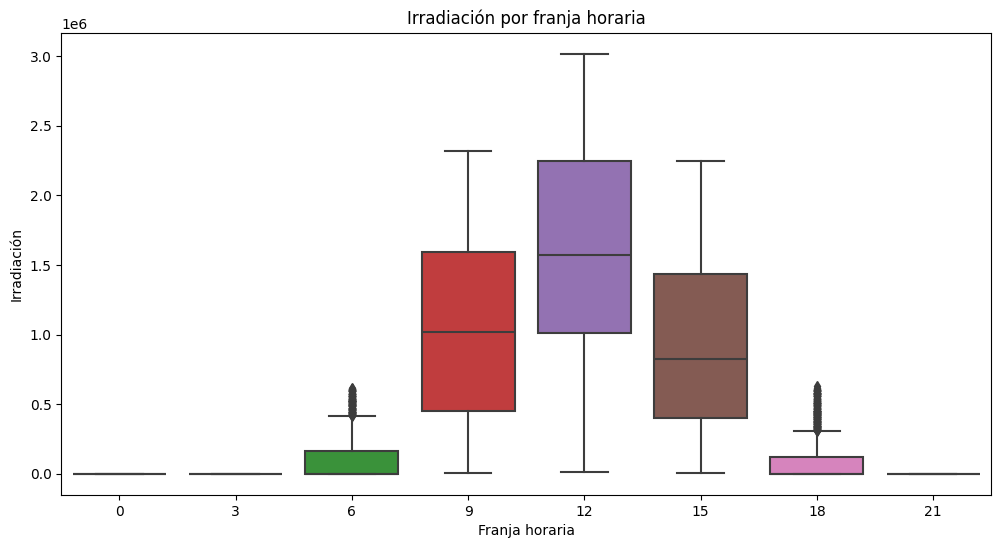

In [18]:
# Irradiación por franja horaria
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_final, x='FranjaHoraria', y='Irradiacion')
plt.title('Irradiación por franja horaria')
plt.xlabel('Franja horaria')
plt.ylabel('Irradiación')



Text(0, 0.5, 'Utilización')

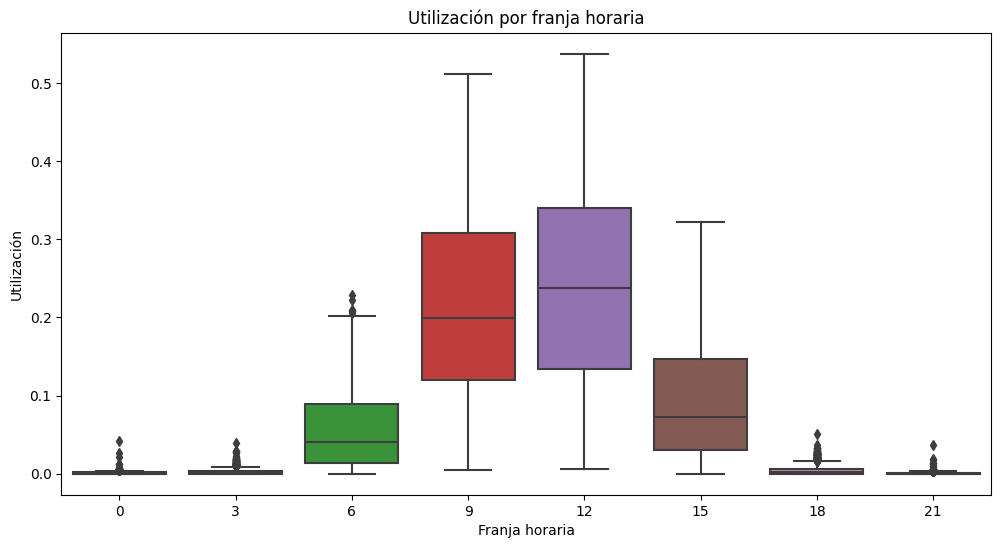

In [19]:
# Utilización por franja horaria    
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_final, x='FranjaHoraria', y='Utilizacion')
plt.title('Utilización por franja horaria')
plt.xlabel('Franja horaria')
plt.ylabel('Utilización')


#### 3.4 Pairplots

Text(0.5, 1.02, 'Pairplot de irradiación y utilización')

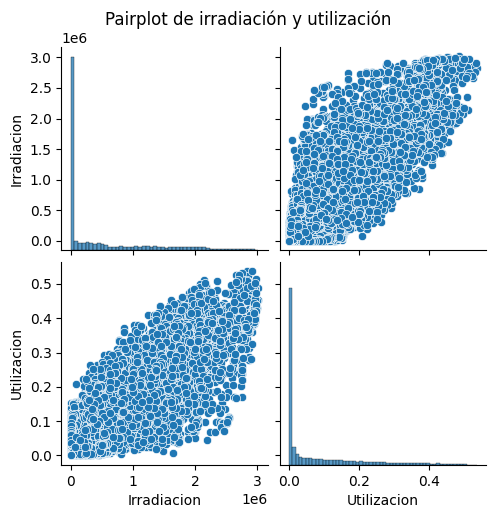

In [20]:
# Pairplot:
sns.pairplot(df_final[['Irradiacion', 'Utilizacion']])
plt.suptitle('Pairplot de irradiación y utilización', y=1.02)


A strong linear relationship can be reported between each variable in the IRRADHXX series and its adjacent variables for XX in ['09', '12', '15']. As the IRRADHXX coefficient is calculated as the cumulative sum of irradiation over three consecutive time periods (XX, XX+1, XX+2), and taking into consideration the typical temperature patterns throughout the day, this relationship is logical.

Newly, a strong linear relationship exists between each variable in the UTILHXX series and its adjacent variables.

#### 3.5 Correlation Matrix

Text(0.5, 1.0, 'Correlación entre irradiación y utilización')

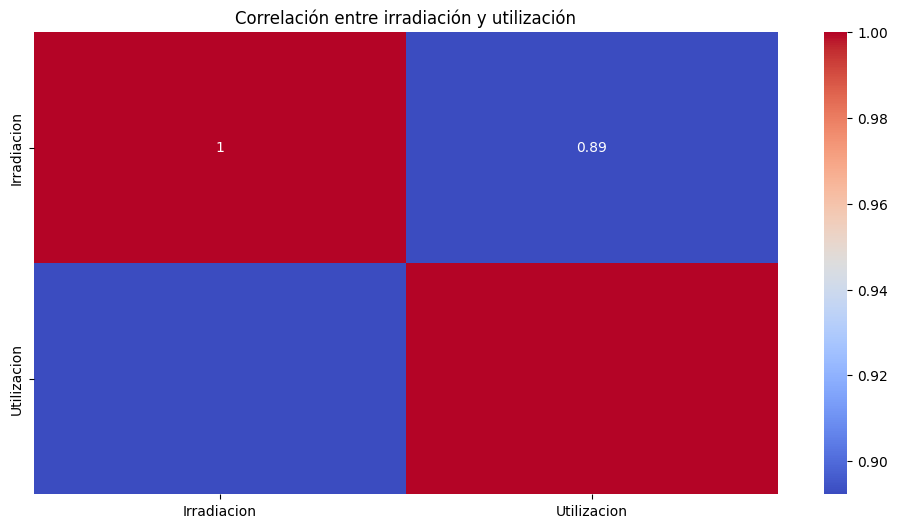

In [21]:
# Correlation between numeric variables (graphical)
plt.figure(figsize=(12, 6))
sns.heatmap(df_final[['Irradiacion', 'Utilizacion']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlación entre irradiación y utilización')



#### 3.5 Scatter plot

Text(0, 0.5, 'Utilización')

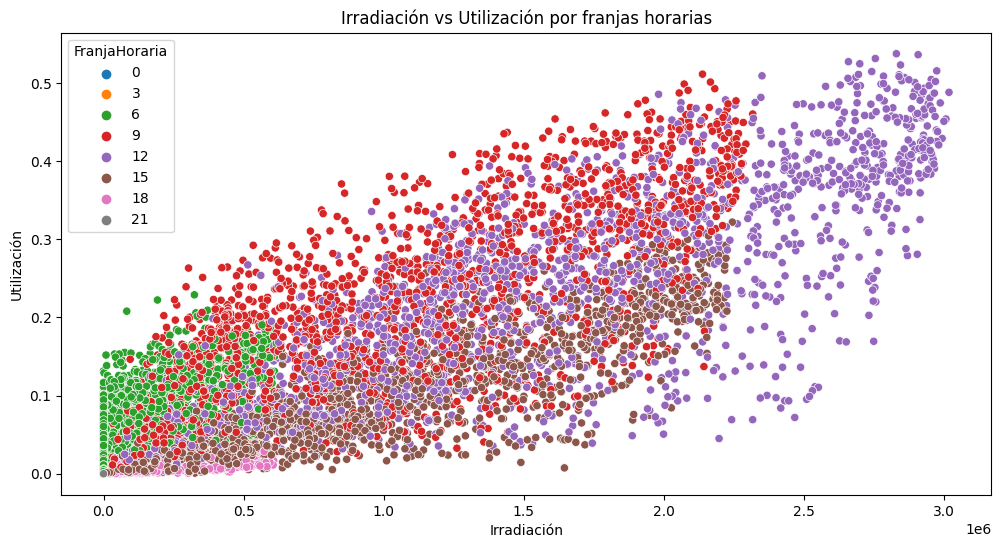

In [22]:
# Irradiación vs utilización por franjas horarias
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_final, x='Irradiacion', y='Utilizacion', hue='FranjaHoraria')
plt.title('Irradiación vs Utilización por franjas horarias')
plt.xlabel('Irradiación')
plt.ylabel('Utilización')

La gráfica que has subido muestra la relación entre la irradiación y la utilización a lo largo de diferentes franjas horarias del día. Basándome en los colores, parece que los puntos están codificados por hora, lo que nos permite ver cómo se comporta esta relación en diferentes momentos del día. Aquí hay algunas observaciones que podemos hacer:

1. **Relación Positiva:** Hay una tendencia general que sugiere una relación positiva entre la irradiación y la utilización; es decir, a medida que la irradiación aumenta, también lo hace la utilización. Esto es consistente con lo que esperaríamos en un sistema donde la energía solar es convertida y utilizada o almacenada.

2. **Diferencias por Franja Horaria:**
   - Las franjas horarias más tempranas (00, 03) y las más tardías (21) tienen, en general, una menor irradiación y utilización, lo cual tiene sentido dado que estas horas están cerca del amanecer y el atardecer o durante la noche.
   - Las franjas horarias centrales (06, 09, 12, 15, 18), que corresponden a las horas diurnas, muestran una irradiación y una utilización significativamente mayores. Esto indica la generación de energía durante las horas de máxima luz solar.

3. **Saturación o Limitaciones del Sistema:** Algunos puntos con alta irradiación no tienen una utilización proporcionalmente alta, lo que podría indicar que el sistema alcanza su capacidad máxima de utilización o hay un umbral a partir del cual la energía adicional no se utiliza de forma eficiente.

4. **Variabilidad en la Utilización:** Aunque la irradiación parece aumentar de manera continua y concentrada, la utilización muestra una mayor variabilidad. Esto podría deberse a la eficiencia del sistema, condiciones de operación variables, o a la presencia de otros factores que afectan cómo se consume la energía generada.

5. **Eficiencia del Sistema:** En las franjas horarias con la mayor irradiación (probablemente mediodía), parece haber una gran dispersión en la utilización, lo que podría sugerir que la eficiencia del sistema varía. Por ejemplo, algunos sistemas pueden estar mejor diseñados o ubicados y, por tanto, utilizan la irradiación de manera más eficiente.

6. **Datos Atípicos:** Algunos datos atípicos, especialmente aquellos con baja irradiación y alta utilización, o viceversa, pueden ser interesantes para una investigación más detallada, ya que podrían indicar anomalías en el sistema o errores de medición.

En resumen, esta gráfica proporciona una buena visión general de cómo la irradiación y la utilización están correlacionadas y cómo esta correlación varía en diferentes momentos del día. Para sacar conclusiones más definitivas, sería útil considerar la configuración específica del sistema, las condiciones locales, y otros factores operacionales o ambientales que podrían influir en estos resultados.